In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import accuracy_score

from warnings import filterwarnings
filterwarnings('ignore')

In [21]:
data = pd.read_csv('./exam_superv.csv')
print(f'data size is: {data.shape}')
data.head()

data size is: (1200, 4)


,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


In [3]:
data.describe()

,0,1,y,2
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,0.507500,2.494236
std,0.804770,0.507227,0.500152,0.589235
min,0.343023,0.509424,0.000000,1.500260
25%,1.806657,1.809635,0.000000,1.974389
50%,2.744439,1.983524,1.000000,2.469778
75%,3.092275,2.201484,1.000000,2.995198
max,3.529782,3.647299,1.000000,3.498523


In [4]:
data.isnull().sum() > 0

0    False
1    False
y    False
2    False
dtype: bool

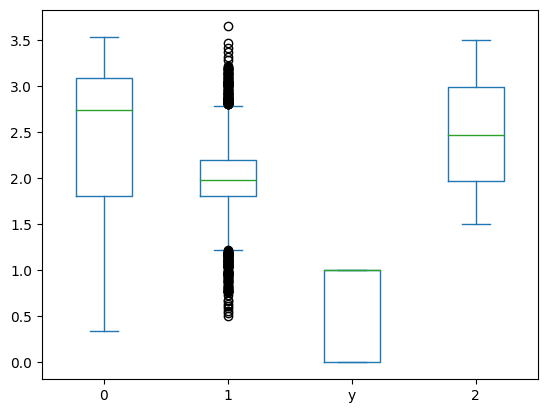

In [6]:
data.plot.box();

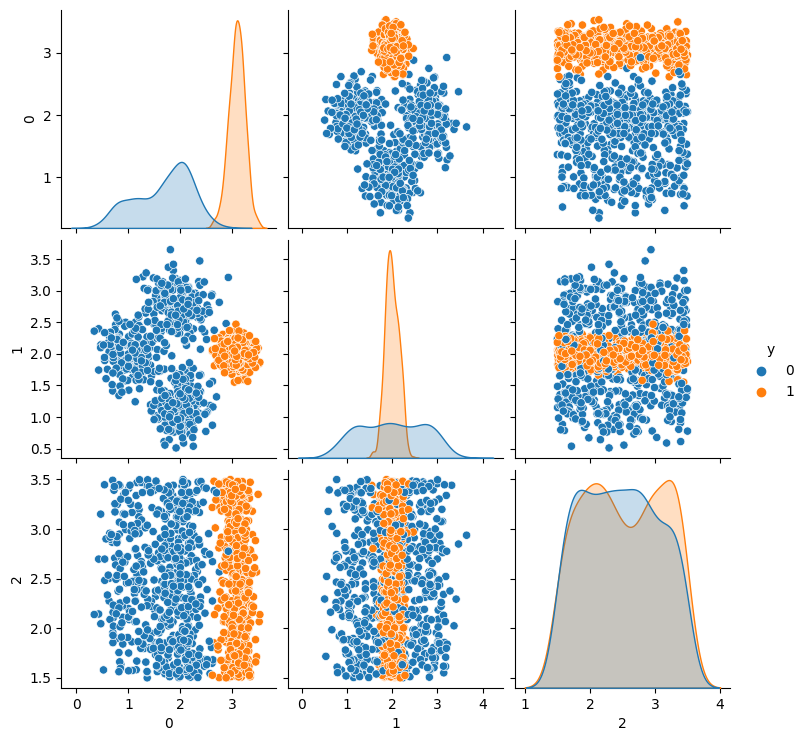

In [9]:
sns.pairplot(data, hue='y');

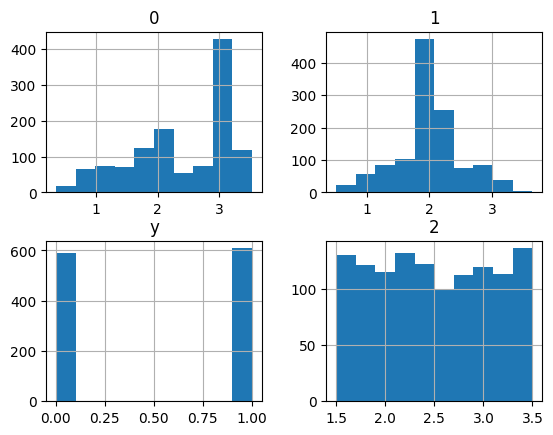

In [17]:
data.hist();

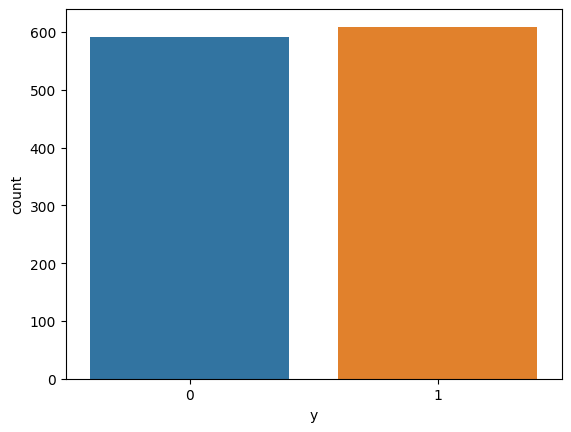

In [19]:
sns.countplot(x=data['y']);

In [11]:
X = data.drop('y', axis=1)
y = data['y']
X = X.drop('2', axis=1)

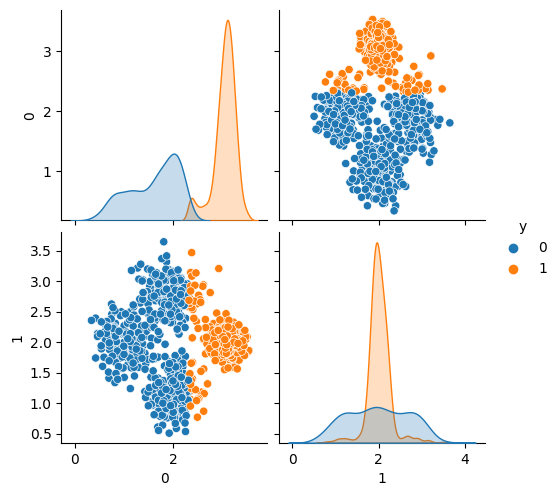

In [49]:
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
data_to_plot = X.copy()
data_to_plot['y'] = y_pred
sns.pairplot(data_to_plot, hue='y');

In [47]:
def two_plots(x, y1, y2, xlabel, y1label, y2label):

	fig, ax1 = plt.subplots()
	
	color = 'tab:red'
	ax1.set_xlabel(xlabel)
	ax1.set_ylabel(y1label, color=color)
	ax1.plot(x, y1, color=color)
	ax1.tick_params(axis='y', labelcolor=color)
	
	ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
	color = 'tab:blue'
	ax2.set_ylabel(y2label, color=color) # we already handled the x-label with ax1
	ax2.plot(x, y2, color=color)
	ax2.tick_params(axis='y', labelcolor=color)
	ax2.set_ylim(0,1) # the axis for silhouette is [0,1]
	fig.tight_layout() # otherwise the right y-label is slightly clipped
	
	plt.show()

def transform(y_true, y_pred):
	y_mapped = y_pred.copy()
	for lab in np.unique(y_pred):
		if lab in np.unique(y_true):
			true_l, count = np.unique(y_true[y_pred==lab], return_counts=True)
			y_mapped[y_pred==lab] = true_l[np.argmax(count)]
		else:
			y_mapped[y_pred==lab] = lab
	return y_mapped

In [51]:
print(f'the inertia of kmeans with 2 clusters is: {kmeans.inertia_}')
print(f'the silhouette of kmeans with 2 clusters is: {silhouette_score(X, y_pred)}')
print(f'the accuracy of kmeans with 2 clusters is: {accuracy_score(y, transform(y, y_pred))}')

the inertia of kmeans with 2 clusters is: 473.7300685703037
the silhouette of kmeans with 2 clusters is: 0.5571687955697787
the accuracy of kmeans with 2 clusters is: 0.9575


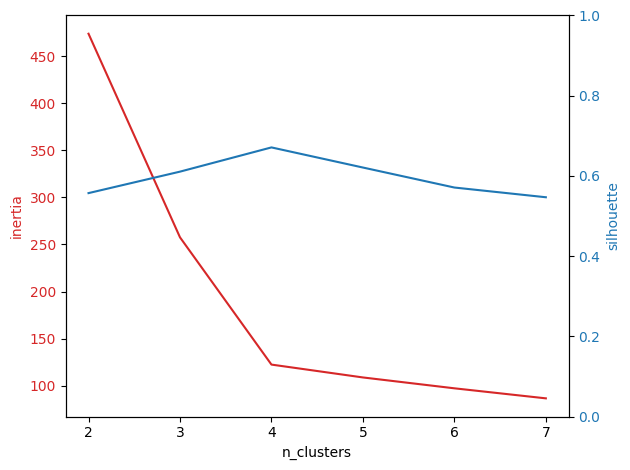

In [44]:
params = [{'n_clusters':range(2,8)}]
parameters = list(ParameterGrid(params))

silhouette_values = []
inertia_values = []

for i in range(len(parameters)):
    kmeans = KMeans(**(parameters[i]), random_state=42)
    y_pred = kmeans.fit_predict(X)
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X, y_pred))

two_plots(range(2,8), inertia_values, silhouette_values, 'n_clusters', 'inertia', 'silhouette')


the inertia of kmeans with 4 clusters is: 122.49868932109139
the silhouette of kmeans with 4 clusters is: 0.6711112537189202
the accuracy of kmeans with 4 clusters is: 0.6625
the confusion matrix of kmeans with 4 clusters is:
[[713748   6090]
 [234660 484302]]


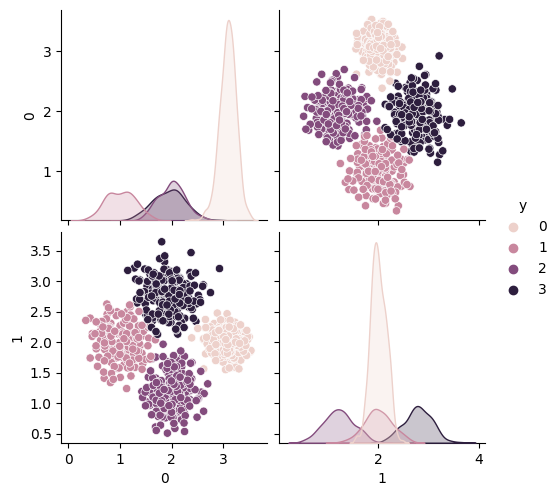

In [52]:
kmeans = KMeans(n_clusters=4)
y_pred = kmeans.fit_predict(X)
data_to_plot = X.copy()
data_to_plot['y'] = y_pred
print(f'the inertia of kmeans with 4 clusters is: {kmeans.inertia_}')
print(f'the silhouette of kmeans with 4 clusters is: {silhouette_score(X, y_pred)}')
print(f'the accuracy of kmeans with 4 clusters is: {accuracy_score(y, transform(y, y_pred))}')
print(f'the confusion matrix of kmeans with 4 clusters is:')
print(pair_confusion_matrix(y, y_pred))
sns.pairplot(data_to_plot, hue='y');

In [53]:
def k_distance(X, k):

	k_distances = []
	for i in range(0, X.shape[0]):
		k_point_distances = []
		for j in range(0, X.shape[0]):
			if i!=j:
				dist = np.sqrt(sum((X[i,:]-X[j,:])**2))
				k_point_distances.append(dist)
		k_point_distances.sort()
		k_distances.append(k_point_distances[k-1])
		
	k_distances.sort(reverse=True)
	return k_distances

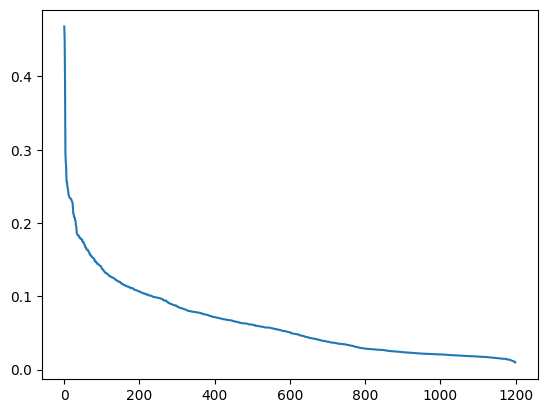

In [57]:
starting_min_sample = 2 * X.shape[1]
k_distances = k_distance(np.array(X), starting_min_sample)
plt.plot(range(len(k_distances)), k_distances)
plt.show();

In [68]:
params = [{'eps':np.arange(0.05,0.25, 0.01), 'min_samples': range(starting_min_sample // 2, starting_min_sample * 2)}]
parameters = list(ParameterGrid(params))

results = []

for i in range(len(parameters)):
    dbscan = DBSCAN(**(parameters[i]))
    y_pred = dbscan.fit_predict(X)
    n_clusters = len(np.unique(y_pred[y_pred != -1]))
    if n_clusters > 1:
        row = parameters[i].copy()
        silhouette_value = silhouette_score(X, y_pred)
        row['silhouette'] = silhouette_value
        row['accuracy'] = accuracy_score(y, transform(y, y_pred))
        row['n_clusters'] = n_clusters
        row['i'] = i
        results.append(row)


In [70]:
results_dataframe = pd.DataFrame(results)
results_dataframe.sort_values(by=['silhouette', 'accuracy'], ascending=False, inplace=True)
results_dataframe.head()

,eps,min_samples,silhouette,accuracy,n_clusters,i
75,0.17,6,0.586845,0.819167,3,76
81,0.18,7,0.585284,0.817500,3,83
76,0.17,7,0.583005,0.815000,3,77
71,0.16,7,0.582226,0.805833,3,71
70,0.16,6,0.582004,0.811667,3,70


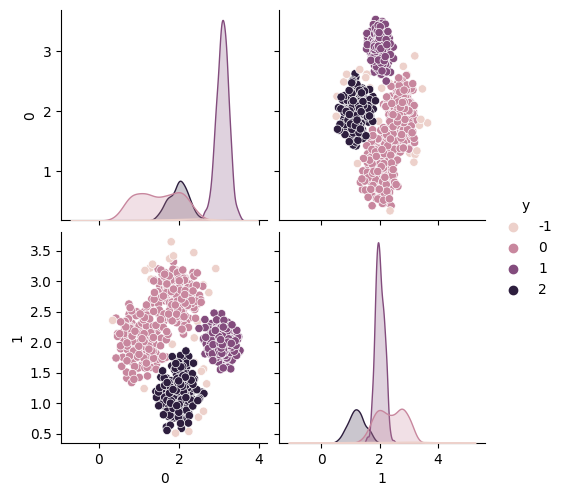

In [73]:
dbscan = DBSCAN(**(parameters[int(results_dataframe.iloc[0]['i'])]))
y_pred = dbscan.fit_predict(X)
data_to_plot['y'] = y_pred
sns.pairplot(data_to_plot, hue='y');

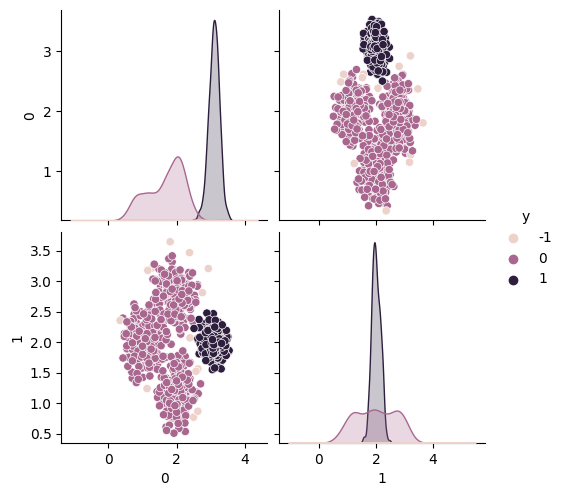

In [75]:
results_dataframe = pd.DataFrame(results)
results_dataframe.sort_values(by=['accuracy', 'silhouette'], ascending=False, inplace=True)
dbscan = DBSCAN(**(parameters[int(results_dataframe.iloc[0]['i'])]))
y_pred = dbscan.fit_predict(X)
data_to_plot['y'] = y_pred
sns.pairplot(data_to_plot, hue='y');

In [76]:
results_dataframe.head()

,eps,min_samples,silhouette,accuracy,n_clusters,i
78,0.18,4,0.510283,0.986667,2,80
79,0.18,5,0.514710,0.985000,2,81
86,0.20,7,0.509362,0.985000,2,95
83,0.19,6,0.509608,0.984167,2,88
73,0.17,4,0.509458,0.984167,2,74
